# WG Probabilistic Results Processing: Sabinal Basin

The purpose of this notebook is to process weather generator results into Climate Normals and cones of uncertainty for comparison with CMIP projections and historical observations.

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as sstats
from math import exp
import datetime as dt
import pickle
from copy import deepcopy

In [3]:
BasKey = "Sabinal"

In [4]:
NumReal = 1000

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
IN_DIR1 = r'C:\Users\nmartin\Documents\EAA_Drought_Future_Weather\NumModels\Final\%s\Results\Simulated' % BasKey
IN_DIR2 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\LOCA2'
IN_DIR3 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\Processed_Historical'
OUT_DIR = r'C:\Users\nmartin\Documents\EAA_Drought_Future_Weather\NumModels\Final\%s\Results\Processed' % BasKey

In [7]:
CNStartTS = pd.Timestamp( 2031, 1, 1, )
CNStopTS = pd.Timestamp( 2060, 12, 31, 23, 59, )
CNMonIndexer = pd.date_range( start=CNStartTS, end=CNStopTS, freq='MS' )
len( CNMonIndexer )

360

In [8]:
CUStartTS = pd.Timestamp( 2025, 1, 1, )
CUStopTS = pd.Timestamp( 2065, 12, 31, 23, 59, )
CUYearsIndexer = [ pd.Timestamp(x, 7, 1, 0) for x in range(CUStartTS.year, CUStopTS.year + 1) ]
len( CUYearsIndexer )

41

In [9]:
fillIndexer = deepcopy( CUYearsIndexer )
fillIndexer[0] = pd.Timestamp(2025, 1, 1, 0)
fillIndexer[len(fillIndexer)-1] = pd.Timestamp(2065, 12, 31, 23, 59, )

In [10]:
# make the Date indices
NumPolyPlotPts = len( fillIndexer )
NumPolyPlotPts

41

In [11]:
# make the time polygon list
DTTimeList = deepcopy( fillIndexer )
BackDTList = deepcopy( fillIndexer )
BackDTTL = BackDTList[::-1]
DTTimeList.extend( BackDTTL )

In [12]:
ColsList = list()
for cR in range(1, NumReal+1):
    ColsList.append( "R%04d" % cR )
# end for

In [13]:
OurQs = np.array( [ round( 0.05 * x, 2 ) for x in range(21) ], dtype=np.float32 )
NumQs = len( OurQs )
NumQs

21

In [14]:
InFiler = os.path.normpath( os.path.join( IN_DIR3, "CN1991to2020_Basin_DictDF.pkl" ) )
with open( InFiler, 'rb' )  as IF:
    CNObsBasinDict = pickle.load( IF )
# end with
ObsCN = CNObsBasinDict[BasKey]

In [15]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CN2031_2060", "EnsAveCNDictnp.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    L2CNBasinDict = pickle.load( IF )
# end with
L2CN = L2CNBasinDict[BasKey]

In [16]:
ProjFileRoot = "%s_R%d_DF.pickle"
MonIndexer = [ x for x in range(1,13,1)]

In [17]:
TSTicks = [ pd.Timestamp( 2025, 1, 1, ), pd.Timestamp( 2030, 1, 1, ), pd.Timestamp( 2035, 1, 1, ), pd.Timestamp( 2040, 1, 1, ),
            pd.Timestamp( 2045, 1, 1, ), pd.Timestamp( 2050, 1, 1, ), pd.Timestamp( 2055, 1, 1, ), pd.Timestamp( 2060, 1, 1, ),
            pd.Timestamp( 2065, 1, 1, ), ]
TSLabels = [ 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, ]

In [18]:
TempYVals = [ 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, ]
PreYVals = [ 0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0, 2000.0 ]

## Process Weather Generator Results

Need monthly values for the Climate Normals and Annual Values for the Cones of Uncertainty

In [19]:
MonPreDF = pd.DataFrame( 0.0, index=CNMonIndexer, columns=ColsList, dtype=np.float32 )
MonMaxTDF = pd.DataFrame( 0.0, index=CNMonIndexer, columns=ColsList, dtype=np.float32 )
MonMinTDF = pd.DataFrame( 0.0, index=CNMonIndexer, columns=ColsList, dtype=np.float32 )
AnnPreDF = pd.DataFrame( 0.0, index=CUYearsIndexer, columns=ColsList, dtype=np.float32 )
AnnTempDF = pd.DataFrame( 0.0, index=CUYearsIndexer, columns=ColsList, dtype=np.float32 )

In [20]:
for cR in range(1, NumReal+1):
    curCol = "R%04d" % cR
    InFiler = os.path.normpath( os.path.join( IN_DIR1, ProjFileRoot % (BasKey, cR) ) )
    curDF = pd.read_pickle( InFiler, compression='zip' )
    cPreDF = curDF[["Precip_mm"]].copy()
    cPreDF.columns = ["Pre_mm"]
    cMaxTDF = curDF[["Tmax_C"]].copy()
    cMinTDF = curDF[["Tmin_C"]].copy()
    cAveTDF = curDF[["Tave_C"]].copy()
    curMonPre = cPreDF.resample( 'MS' ).sum()
    curAnnPre = cPreDF.resample( 'AS' ).sum()
    curMonMaxT = cMaxTDF.resample( 'MS' ).mean()
    curMonMinT = cMinTDF.resample( 'MS' ).mean()
    curAnnTemp = cAveTDF.resample('AS').mean()
    # set to the correct time durations
    curMonPre = curMonPre.loc[CNStartTS:CNStopTS].copy()
    curMonMaxT = curMonMaxT.loc[CNStartTS:CNStopTS].copy()
    curMonMinT = curMonMinT.loc[CNStartTS:CNStopTS].copy()
    curAnnPre = curAnnPre.loc[CUStartTS:CUStopTS].copy()
    curAnnTemp = curAnnTemp.loc[CUStartTS:CUStopTS].copy()
    # now assign to our columns in tracking DataFrames
    MonPreDF[curCol] = curMonPre["Pre_mm"].to_numpy(dtype=np.float32)
    MonMaxTDF[curCol] = curMonMaxT["Tmax_C"].to_numpy(dtype=np.float32)
    MonMinTDF[curCol] = curMonMinT["Tmin_C"].to_numpy(dtype=np.float32)
    AnnPreDF[curCol] = curAnnPre["Pre_mm"].to_numpy(dtype=np.float32)
    AnnTempDF[curCol] = curAnnTemp["Tave_C"].to_numpy(dtype=np.float32)
# end for

Add the ensemble averages for monthly DataFrames

In [21]:
MonPreDF["EnsAve"] = MonPreDF.mean(axis=1)
MonMaxTDF["EnsAve"] = MonMaxTDF.mean(axis=1)
MonMinTDF["EnsAve"] = MonMinTDF.mean(axis=1)
ColsList.append( "EnsAve" )

Build the pivot tables

In [22]:
MonPreDF["Year"] = MonPreDF.index.year
MonMaxTDF["Year"] = MonMaxTDF.index.year
MonMinTDF["Year"] = MonMinTDF.index.year

In [23]:
MonPreDF["Month"] = MonPreDF.index.month
MonMaxTDF["Month"] = MonMaxTDF.index.month
MonMinTDF["Month"] = MonMinTDF.index.month

In [24]:
pvPptDF = pd.pivot_table( MonPreDF[["Year", "Month", "EnsAve"]], values="EnsAve", index="Year", 
                          columns="Month", aggfunc='mean' )
pvPptDF1 = pvPptDF.copy()
pvPptDF1["Ann_Total"] = pvPptDF.sum( axis=1 )
pvPptDF1.loc["Max"] = pvPptDF.max( axis=0 )
pvPptDF1.loc["Mean"] = pvPptDF.mean( axis=0 )
pvPptDF1.loc["Median"] = pvPptDF.median( axis=0 )
pvPptDF1.loc["Min"] = pvPptDF.min( axis=0 )
pvPptDF1.loc["StDev"] = pvPptDF.std( axis=0 )
np_MeanPre = pvPptDF.mean( axis=0 ).to_numpy(dtype=np.float32).flatten()

In [25]:
pvTmaxDF = pd.pivot_table( MonMaxTDF[["Year", "Month", "EnsAve"]], values="EnsAve", index="Year", 
                          columns="Month", aggfunc='mean' )
pvTmaxDF1 = pvTmaxDF.copy()
pvTmaxDF1["Ann_Total"] = pvTmaxDF.sum( axis=1 )
pvTmaxDF1.loc["Max"] = pvTmaxDF.max( axis=0 )
pvTmaxDF1.loc["Mean"] = pvTmaxDF.mean( axis=0 )
pvTmaxDF1.loc["Median"] = pvTmaxDF.median( axis=0 )
pvTmaxDF1.loc["Min"] = pvTmaxDF.min( axis=0 )
pvTmaxDF1.loc["StDev"] = pvTmaxDF.std( axis=0 )
np_MeanTMax = pvTmaxDF.mean( axis=0 ).to_numpy(dtype=np.float32).flatten()

In [26]:
pvTminDF = pd.pivot_table( MonMinTDF[["Year", "Month", "EnsAve"]], values="EnsAve", index="Year", 
                          columns="Month", aggfunc='mean' )
pvTminDF1 = pvTmaxDF.copy()
pvTminDF1["Ann_Total"] = pvTminDF.sum( axis=1 )
pvTminDF1.loc["Max"] = pvTminDF.max( axis=0 )
pvTminDF1.loc["Mean"] = pvTminDF.mean( axis=0 )
pvTminDF1.loc["Median"] = pvTminDF.median( axis=0 )
pvTminDF1.loc["Min"] = pvTminDF.min( axis=0 )
pvTminDF1.loc["StDev"] = pvTminDF.std( axis=0 )
np_MeanTMin = pvTminDF.mean( axis=0 ).to_numpy(dtype=np.float32).flatten()

Do the statistics for the annual DataFrames and the Cones of Uncertainty

In [27]:
PreQDict = dict()
AveTQDict = dict()

In [28]:
for cQ in OurQs.tolist():
    curLabel = "q%3.2f" % cQ
    PreQDict[curLabel] = AnnPreDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
    AveTQDict[curLabel] = AnnTempDF.quantile(q=cQ, axis=1).to_numpy(dtype=np.float32).flatten()
# end for

In [29]:
PreQDict["Mean"] = AnnPreDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["Mean"] = AnnTempDF.mean(axis=1).to_numpy(dtype=np.float32).flatten()
PreQDict["StDev"] = AnnPreDF.std(axis=1).to_numpy(dtype=np.float32).flatten()
AveTQDict["StDev"] = AnnTempDF.std(axis=1).to_numpy(dtype=np.float32).flatten()

In [30]:
FutQsPre = pd.DataFrame( index=CUYearsIndexer, data=PreQDict )
FutQsTemp = pd.DataFrame( index=CUYearsIndexer, data=AveTQDict )

Build the plot polygons

In [31]:
PQ5thList = FutQsPre["q0.05"].tolist()
PQ25thList = FutQsPre["q0.25"].tolist()
PQ75thList = FutQsPre["q0.75"].tolist()
PQ95thList = FutQsPre["q0.95"].tolist()

In [32]:
TQ5thList = FutQsTemp["q0.05"].tolist()
TQ25thList = FutQsTemp["q0.25"].tolist()
TQ75thList = FutQsTemp["q0.75"].tolist()
TQ95thList = FutQsTemp["q0.95"].tolist()

In [33]:
# 5th - 95th Envelope
PEnv5to95List = deepcopy( PQ5thList )
Back95List = deepcopy( PQ95thList )
Back95DTTL = Back95List[::-1]
PEnv5to95List.extend( Back95DTTL )

In [34]:
# 25th - 75th Envelope
PEnv25to75List = deepcopy( PQ25thList )
Back75List = deepcopy( PQ75thList )
Back75DTTL = Back75List[::-1]
PEnv25to75List.extend( Back75DTTL )

In [35]:
# 5th - 95th Envelope
TEnv5to95List = deepcopy( TQ5thList )
Back95List = deepcopy( TQ95thList )
Back95DTTL = Back95List[::-1]
TEnv5to95List.extend( Back95DTTL )

In [36]:
# 25th - 75th Envelope
TEnv25to75List = deepcopy( TQ25thList )
Back75List = deepcopy( TQ75thList )
Back75DTTL = Back75List[::-1]
TEnv25to75List.extend( Back75DTTL )

## Plots

### Climate Normals

In [37]:
L2Pre = L2CN["Pre_mm"]
L2MaxT = L2CN["TMax_C"]
L2MinT = L2CN["TMin_C"]

In [38]:
bWidth = 0.20

In [39]:
monTLabels = [ "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [40]:
wgPreTicks = [ ( x + (1.0*bWidth)) for x in MonIndexer ]
l2PreTicks = [ ( x + (0.0*bWidth)) for x in MonIndexer ]
obsPreTicks = [ ( x - (1.0*bWidth)) for x in MonIndexer ]

In [41]:
preTicks = [ 0.0, 50.0, 100.0, 150.0, 200.0, 250.0, ]
tmpTicks = [ 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, ]

In [42]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_ClimateNormals_2031to2060.svg" % BasKey ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_ClimateNormals_2031to2060.png" % BasKey ) )
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_ClimateNormals_2031to2060.pdf" % BasKey ) )

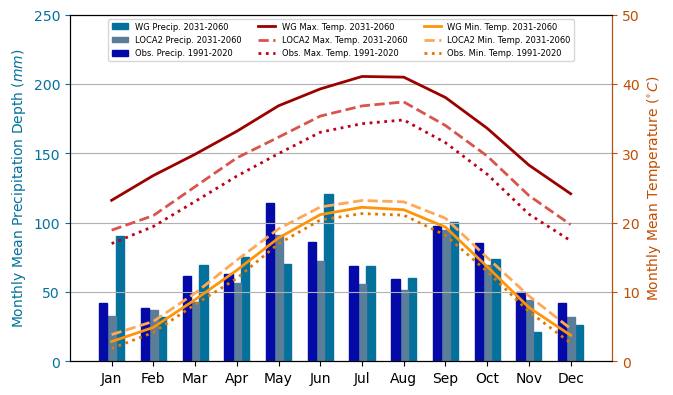

In [43]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 4.5)
ax11 = Fig1.add_subplot(111)
wgPre = ax11.bar( wgPreTicks, np_MeanPre, bWidth, color='xkcd:ocean blue', edgecolor='xkcd:ocean blue',
                  label="WG 2031-2060" )
l2Pre = ax11.bar( l2PreTicks, L2Pre, bWidth, color='xkcd:steel blue', edgecolor='xkcd:steel blue',
                  label="LOCA2 2031-2060" )
obsPre = ax11.bar( obsPreTicks, ObsCN["Pre_mm"], bWidth, color='xkcd:cobalt blue', edgecolor='xkcd:cobalt blue',
                   label="Obs. 1991-2020" )
ax11.set_xticks( MonIndexer )
ax11.set_yticks( preTicks )
ax11.set_xticklabels( monTLabels, minor=False, rotation=0 )
ax11.set_ylabel('Monthly Mean Precipitation Depth ($mm$)', fontsize=10, color='xkcd:ocean blue')
ax11.set_xlim( (0.0, 13.0) )
ax11.set_ylim( (preTicks[0], preTicks[len(preTicks)-1]) )
ax11.tick_params(axis='both', which='major', labelsize=10)
ax11.tick_params(axis='y', colors='xkcd:ocean blue')
ax11.spines["right"].set_color('xkcd:ocean blue')
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
# second plot - temperatures
ax21 = ax11.twinx()
wgMxT, = ax21.plot( MonIndexer, np_MeanTMax, linestyle='-', linewidth=2, color='xkcd:deep red', 
                    label="WG Max. Temp. 2031-2060" )
l2MxT, = ax21.plot( MonIndexer, L2MaxT, linestyle='dashed', linewidth=2, color='xkcd:pale red',
                    label="LOCA2 Max. Temp. 2031-2060" )
obsMxT, = ax21.plot( ObsCN.index, ObsCN["MaxT_C"], linestyle=':', linewidth=2, color='xkcd:scarlet',
                     label="Obs. Max. Temp. 1991-2020" )
wgMnT, = ax21.plot( MonIndexer, np_MeanTMin, linestyle='-', linewidth=2, color='xkcd:tangerine', 
                    label="WG Min. Temp. 2031-2060" )
l2MnT, = ax21.plot( MonIndexer, L2MinT, linestyle='dashed', linewidth=2, color='xkcd:pale orange',
                    label="LOCA2 Min. Temp. 2031-2060" )
obsMnT, = ax21.plot( ObsCN.index, ObsCN["MinT_C"], linestyle=':', linewidth=2, color='xkcd:pumpkin',
                     label="Obs. Min. Temp. 1991-2020" )
ax21.set_yticks( tmpTicks )
ax21.set_ylabel('Monthly Mean Temperature ($ ^{\circ} C$)', fontsize=10, color='xkcd:burnt orange')
ax21.spines["right"].set_color('xkcd:burnt orange')
ax21.set_ylim( (tmpTicks[0], tmpTicks[len(tmpTicks)-1]) )
ax21.tick_params(axis='y', which='major', labelsize=10, colors='xkcd:burnt orange')
ax11.legend( ( wgPre, l2Pre, obsPre, 
               wgMxT, l2MxT, obsMxT, 
               wgMnT, l2MnT, obsMnT, ), 
             ( "WG Precip. 2031-2060", "LOCA2 Precip. 2031-2060", "Obs. Precip. 1991-2020", 
                "WG Max. Temp. 2031-2060", "LOCA2 Max. Temp. 2031-2060", "Obs. Max. Temp. 1991-2020", 
                "WG Min. Temp. 2031-2060", "LOCA2 Min. Temp. 2031-2060", "Obs. Min. Temp. 1991-2020", ),
             loc='upper center', fontsize=6, ncol=3 )
ax11.grid(visible=True, which='major', axis='y' )
ax21.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )
Fig1.savefig( OutPDF, dpi=600.0 )

### Cones of Uncertainty

In [44]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.pdf" % BasKey ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.svg" % BasKey ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_AveTmp_ConeUnc_2025to2065.png" % BasKey ) )

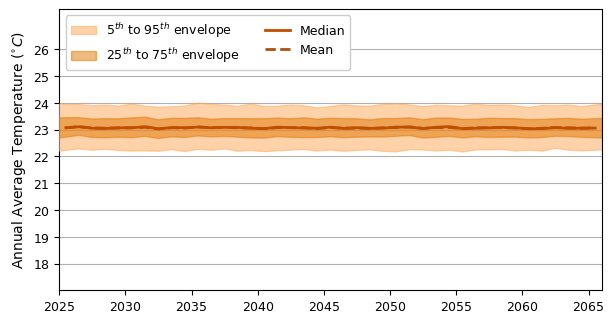

In [45]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, TEnv5to95List, color='xkcd:pale orange', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, TEnv25to75List, color='xkcd:pumpkin', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsTemp.index, FutQsTemp["q0.50"].tolist(), color='xkcd:burnt orange',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsTemp.index, FutQsTemp["Mean"].tolist(), color='xkcd:burnt sienna',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Average Temperature ($^{\circ}C$)', fontsize=10)
ax11.set_yticks( TempYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]) )
ax11.set_ylim( (17, 27.5 ) )
ax11.legend( loc='upper left', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

In [46]:
OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.pdf" % BasKey ) ) 
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.svg" % BasKey ) )
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_PreDep_ConeUnc_2025to2065.png" % BasKey ) )

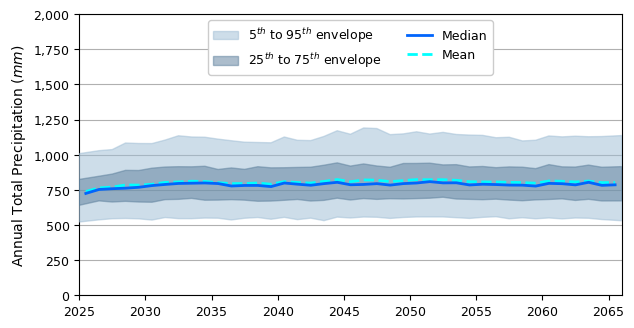

In [47]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 3.65)
ax11 = Fig1.add_subplot(1,1,1)
f5to95 = ax11.fill( DTTimeList, PEnv5to95List, color='xkcd:light grey blue', alpha=0.50, 
                    label="$5^{th}$ to $95^{th}$ envelope", zorder=5 )
f25to75 = ax11.fill( DTTimeList, PEnv25to75List, color='xkcd:steel blue', alpha=0.50, 
                     label="$25^{th}$ to $75^{th}$ envelope", zorder=8 )
med, = ax11.plot( FutQsPre.index, FutQsPre["q0.50"].tolist(), color='xkcd:bright blue',
                  linestyle='-', linewidth=2.0, label="Median", zorder=11 )
ave, = ax11.plot( FutQsPre.index, FutQsPre["Mean"].tolist(), color='xkcd:cyan',
                  linestyle='dashed', linewidth=2.0, label="Mean", zorder=10 )
ax11.set_ylabel( r'Annual Total Precipitation ($mm$)', fontsize=10)
ax11.set_yticks( PreYVals )
ax11.set_xticks( TSTicks )
ax11.set_xticklabels( TSLabels )
ax11.grid( visible=True, which='major', axis='y' )
ax11.set_xlim( (fillIndexer[0], fillIndexer[len(fillIndexer)-1]))
ax11.set_ylim( (PreYVals[0], PreYVals[len(PreYVals)-1]) )
ax11.legend( loc='upper center', ncol=2, framealpha=1.0, fontsize=9)
ax11.tick_params(axis='both', which='major', labelsize=9)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutPDF, dpi=600.0 )
Fig1.savefig( OutSVG, dpi=600.0 )
Fig1.savefig( OutPNG, dpi=600.0 )

## Output

In [48]:
OutFiler = os.path.normpath( os.path.join( OUT_DIR, "ClimateNormals_%s_2031to2060.xlsx" % BasKey ) )
writer = pd.ExcelWriter( OutFiler )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00'})
cLabel = "MonTot_Pre"
MonPreDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(MonPreDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = MonPreDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "MonAve_TMax"
MonMaxTDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(MonMaxTDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = MonMaxTDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "MonAve_TMin"
MonMinTDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime", columns=ColsList )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in ColsList:
    column_width = max(MonMinTDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = MonMinTDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "PvT_Pre"
pvPptDF1.to_excel( writer, sheet_name=cLabel, )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in pvPptDF1:
    if column in [1,2,3,4,5,6,7,8,9,10,11,12]:
        column_width = max(pvPptDF1[column].astype(str).map(len).max()+6, len("%d" % column)+6)
    else:
        column_width = max(pvPptDF1[column].astype(str).map(len).max()+6, len(column)+6)
    # end if
    col_idx = pvPptDF1.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "PvT_TMax"
pvTmaxDF1.to_excel( writer, sheet_name=cLabel, )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in pvTmaxDF1:
    if column in [1,2,3,4,5,6,7,8,9,10,11,12]:
        column_width = max(pvTmaxDF1[column].astype(str).map(len).max()+6, len("%d" % column)+6)
    else:
        column_width = max(pvTmaxDF1[column].astype(str).map(len).max()+6, len(column)+6)
    # end if
    col_idx = pvTmaxDF1.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "PvT_TMin"
pvTminDF1.to_excel( writer, sheet_name=cLabel, )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in pvTminDF1:
    if column in [1,2,3,4,5,6,7,8,9,10,11,12]:
        column_width = max(pvTminDF1[column].astype(str).map(len).max()+6, len("%d" % column)+6)
    else:
        column_width = max(pvTminDF1[column].astype(str).map(len).max()+6, len(column)+6)
    # end if
    col_idx = pvTminDF1.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()

In [49]:
OutFiler = os.path.normpath( os.path.join( OUT_DIR, "Cones_of_Uncertainty_%s_2025to2065.xlsx" % BasKey ) )
writer = pd.ExcelWriter( OutFiler )
workbook  = writer.book
format1 = workbook.add_format({'num_format': '#,##0.00'})
cLabel = "AnnAve_Temp"
AnnTempDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in AnnTempDF:
    column_width = max(AnnTempDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = AnnTempDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "AnnTot_Pre"
AnnPreDF.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in AnnPreDF:
    column_width = max(AnnPreDF[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = AnnPreDF.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Temp_Stats"
FutQsTemp.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in FutQsTemp:
    column_width = max(FutQsTemp[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = FutQsTemp.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
cLabel = "Pre_Stats"
FutQsPre.to_excel( writer, sheet_name=cLabel, index_label="DateTime" )
# adjust columns
writer.sheets[cLabel].set_column( 0, 0, 18 )
for column in FutQsPre:
    column_width = max(FutQsPre[column].astype(str).map(len).max()+6, len(column)+6)
    col_idx = FutQsPre.columns.get_loc(column)
    writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
# end for
writer.close()